## RNN implementations

Today we will implement a RNN model and its variations, but firstly, we need to finish building an MLP as we need to understand the history of developemtn of these models. 

In [56]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

%matplotlib inline

In [57]:
with open("names.txt", "r") as file:
    words = file.read().splitlines()

len(words)

32033

In [58]:
chars = sorted(list(set("".join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)
print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 27


In [59]:
block_size = 3  # context length: how many characters do we take to predict the next one

def build_dataset(words):

    X, Y = [], []
    for w in words:

        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]    # crop and append

    # basically we have a rolling window for context
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [109]:
n_embd = 10     # the dimensionality of the character embedding vectors
n_hidden = 200  # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((block_size*n_embd, n_hidden),  generator=g) * (5/3) / (n_embd * vocab_size)    # * 0.1
b1 = torch.randn(n_hidden,                       generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),         generator=g) * 0.01                             # you do not want to set them to 0 
b2 = torch.randn(vocab_size,                     generator=g) * 0.0                              # you want to set the bias to 0 as you want the initial loss to be lower as well as the logits (no extreme values)

bn_gain = torch.ones((1, n_hidden))
bn_bias = torch.zeros((1, n_hidden))
bn_mean_running = torch.zeros((1, n_hidden))    # not part of gradient based optimization
bn_std_running = torch.ones((1, n_hidden))      # they are updated on the side of training

parameters = [C, W1, b1, W2, b2, bn_gain, bn_bias]

print(f"Total num of elements: {sum(p.nelement() for p in parameters)}")

for p in parameters:
    p.requires_grad = True

Total num of elements: 12297


In [90]:
# NOTE: Kaiming initialization for our data: fan-in is for our model is the vocab_size (since each character is 10-dimensonal) and we have 3 (block_size) of them.
# for tanh the gain is 5/3 (check torch.nn.init docs)
(5/3) / (block_size * vocab_size)

0.0205761316872428

This is what we want our std dev to be upon initialization for our case: 0.0205761316872428

tensor(-0.0005) tensor(1.0075)
tensor(0.0146) tensor(10.0957)


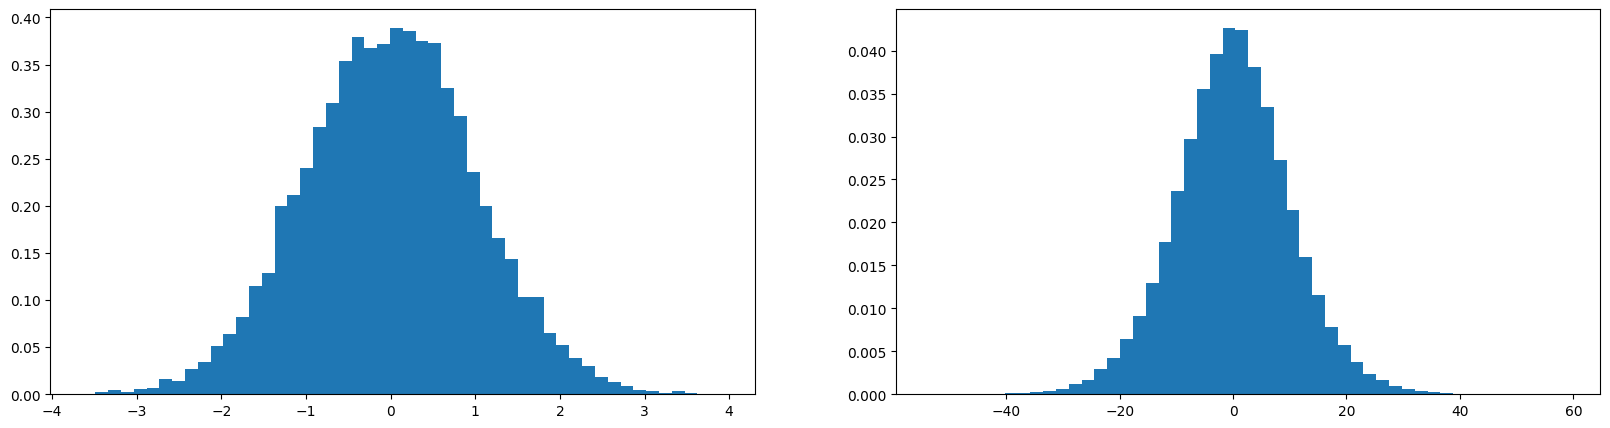

In [91]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) * 10**0.5
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), bins=50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), bins=50, density=True);

We can see that the Gaussian distribution is expanding after multiplication. We want our neural network to have similar activations throughout the neural net. 

How do we preserve this distribution to remain a Gaussian. by scaling the initial vector. Now how do we determine that factor?

Mathematically, the correct answer is that we need to divide it be the square root of fan in(?). 

In our case:

`w = torch.randn(100, 200) * 10**0.5` 

which would be the number of rows or the first element? 

Kaiming initialization: https://www.geeksforgeeks.org/kaiming-initialization-in-deep-learning/

After multiplying by square root of 10 (fan-in) we see that the standard deviation of the product does not change. 


#### In practice, 
use Kaiming init, optimizer and different normalizations tend to minimize the effect of inefficient weight initialization, but if Andrej does it, so will I. 

Just check the standard deviation of weights once it is initialized. 

In [84]:
hpreact.shape
hpreact.mean(dim=0, keepdim=True).shape # we need to have [1, 200] (1, n_hidden) as the neurons needs to be standardized
hpreact.std()

# ((hpreact - hpreact.mean(dim=0, keepdim=True)) / hpreact.var(dim=0, keepdim=True)**0.5).std()
((hpreact - hpreact.mean(dim=0, keepdim=True)) / hpreact.std(dim=0, keepdim=True)).std()

tensor(0.9843, grad_fn=<StdBackward0>)

In [110]:
n_epochs = 200000
batch_size = 32
lossi = []
stepi = []

for i in range(n_epochs):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xbatch, Ybatch = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xbatch]
    hpreact = emb.view(-1, 30) @ W1 + b1    # h pre activation; we do not want them to be too small as tanh will not do anything or too large as tanh will get over-saturated
    # hpreact_norm = bn_gain * (hpreact - hpreact.mean(dim=0, keepdim=True)) / hpreact.std(dim=0, keepdim=True) + bn_bias     # NOTE: this is our batchnorm layer
    bnmeani = hpreact.mean(dim=0, keepdim=True)
    bnstdi = hpreact.std(dim=0, keepdim=True)
    
    hpreact_norm = bn_gain * (hpreact - bnmeani) / bnstdi + bn_bias
    
    # this is how the batch norm layer is implemented in pytorch
    with torch.no_grad():
        # NOTE: they both receive updates in the direction of the what the current mean/std is
        # it is not optimized using gradient descent, but janky update
        bn_mean_running = 0.999 * bn_mean_running + 0.001 * bnmeani
        bn_std_running = 0.999 * bn_std_running + 0.001 * bnstdi

    h = torch.tanh(hpreact_norm)
    logits = h @ W2 + b2
    loss = F.cross_entropy(
        logits, target=Ybatch
    )  # it can be more numerically well behaved (numerically stable)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # lr = lrs[i]
    # parameter update
    lr = 0.1 if i < 100000 else 0.01

    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f"{i:7d}/{n_epochs:7d}: {loss.item():.4f}")
        
    lossi.append(loss.log10().item())
    stepi.append(i)
    
    # break

      0/ 200000: 3.3147
  10000/ 200000: 2.1548
  20000/ 200000: 2.3538
  30000/ 200000: 2.4579
  40000/ 200000: 1.9638
  50000/ 200000: 2.3485
  60000/ 200000: 2.3773
  70000/ 200000: 2.0938
  80000/ 200000: 2.3783
  90000/ 200000: 2.0914
 100000/ 200000: 1.9441
 110000/ 200000: 2.3359
 120000/ 200000: 1.9952
 130000/ 200000: 2.3980
 140000/ 200000: 2.4415
 150000/ 200000: 2.2077
 160000/ 200000: 1.9341
 170000/ 200000: 1.7835
 180000/ 200000: 2.0025
 190000/ 200000: 1.9805


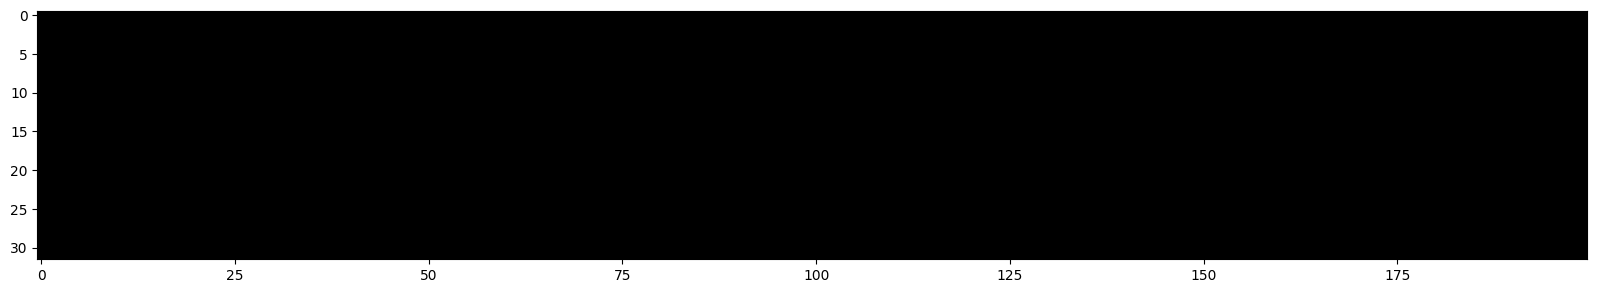

In [51]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap="gray", interpolation="nearest");

# if there is a white column, that is called a dead neuron as the gradients vanish; as we initialize the biases to be zero or close to zero and weights to be 
# a bit higher (factor of 10), we dont have any dead neurons or dead gradients

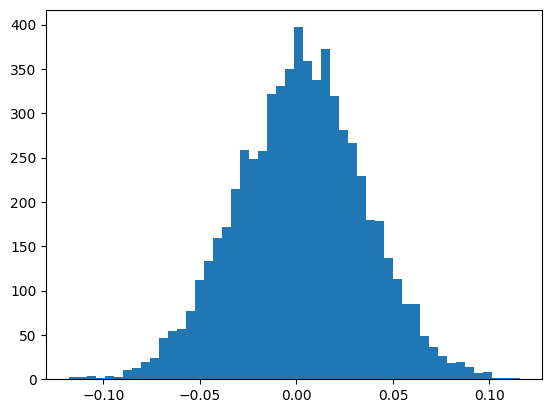

In [52]:
plt.hist(h.view(-1).tolist(), bins=50);

# and we can see that the activation values are more uniformly distributed between -1 and 1 around 0

We can see the distribution of values after tanh activation. 

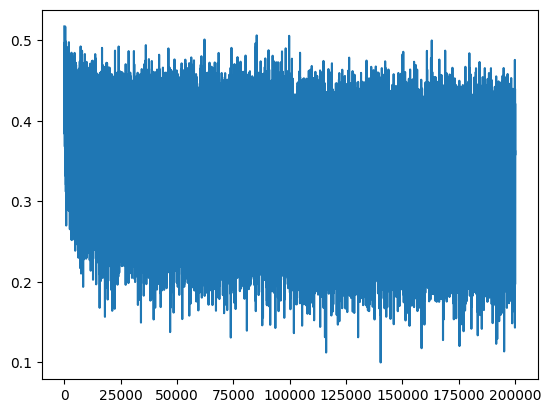

In [54]:
plt.plot(lossi);

## Setting the batch norm for inference

Since it is learning on every batch, we need to calibrate the batch norm at the end of the training to pass through all of the train examples to set the batch norm parameters (batch weights and bias).

In [105]:
C.shape, Xtr.shape, emb.shape

(torch.Size([27, 10]), torch.Size([182625, 3]), torch.Size([32, 3, 10]))

In [106]:
# calibrate the batch norm at the END of the training

with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)     # (N, block_size * n_embed)
    hpreact = embcat @ W1 + b1              # (N, n_hidden)
    # mesaure the mean/std over the ENTIRE training set
    bnmean = hpreact.mean(dim=0, keepdim=True)
    bnstd = hpreact.std(dim=0, keepdim=True)


Since no one wants to do this after training (second stage of traingin basically) the paper introduces that while training we calculate them during training so we have a single stage of training. 

In [111]:
@torch.no_grad
def split_loss(split):
    X, Y = {
        "train" : (Xtr, Ytr),
        "val"   : (Xdev, Ydev),
        "test"  : (Xte, Yte)
    }[split]

    emb = C[X]                              # (N, block_size, n_embed)
    embcat = emb.view(emb.shape[0], -1)     # concat into (N, block_size * n_embed)
    hpreact = embcat @ W1 + b1
    # hpreact_norm = bn_gain * (hpreact - hpreact.mean(dim=0, keepdim=True)) / hpreact.std(dim=0, keepdim=True) + bn_bias
    # NOTE: instead of calculating these dynamically, we are going to fix bnmean and bnstd from the training set and use them for INFERENCE
    hpreact_norm = bn_gain * (hpreact - bn_mean_running) / bn_std_running + bn_bias
    h = torch.tanh(hpreact_norm)        # (N, n_hidden)
    logits = h @ W2 + b2                    # (N, vocab_size)
    loss = F.cross_entropy(logits, target=Y)
    print(split, loss.item())

split_loss("train")
split_loss("val")  

train 2.059842824935913
val 2.106222152709961


These results are the results with correct initialization (no Kaiming init). 

```
train 2.0579607486724854
val 2.1137914657592773
```

The results are more or less the same, with differneces due to the randomness of the training process, but we didnt have to look at histograms of the data to get some arbitrary numbers
but we got a mathematically correct number perfect for our model. 

The results:
```
train 2.1064743995666504
val 2.1390953063964844
```

Adding batch norm layer (also after fixing the bnmean and bnstd vals over train set we get basically identical values):
```
train 2.059947967529297
val 2.1058571338653564
```

Since our initialization was better, the training time could be spent better learning more useful stuff instead of simple stuff that could be solved by correct initialization. 

Our model was shallow, so stuff like these are forgiving. These problems stack up and you incur a debt. The more complex a model is, the less forgiving these types of problems are. 

Correct initialization and stuff like the gradient problems in tanh are more visible in bigger more complex systems. 

In [39]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(10):
    
    out = []
    context = [0] * block_size

    while True:

        # forward pass/inference
        emb = C[torch.tensor(context)]      # (1, block_size * n_embed)
        embcat = emb.view(1, -1)           # concat into (block_size, n_embed)
        h = torch.tanh(embcat @ W1 + b1)    # (1, n_hidden)
        logits = h @ W2 + b2
        probs = torch.softmax(logits, dim=1)

        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)

        if ix == 0:
            break

    print("".join(itos[i] for i in out))

mora.
mayah.
seel.
ndyn.
alee.
thrithadrie.
cadelyn.
elin.
shi.
jen.


## Batch normalization

h pre activation; we do not want them to be too small as tanh will not do anything or too large as tanh will get over-saturated.

We want them to be roughly **Gaussian with std 1.0 at least at initialization.**

The approach/insight from the Google 2015 paper that introduced batch norm: there are these hidden states that you want to be roughly Gaussian so why not take these hidden states and normalize them to be Gaussian. This can be done as standardizing hidden states to be Gaussian is a perfectly differentiazble operation. 

This will make sure that every single neuron and its firing rate will be exactly unit Gaussian **on these 32 examples of this batch.** 

The problem is we will not get any better results as we want these to be **roughly gaussian but only at initializataion.**

We DO NOT WANT THESE to be forced to be Gaussian ALWAYS. We would like to have the neural net to move this around, make neurons more "trigger-happy" or less. We would like this distribution to move around and to have backprop tell us how it moves. 

We have to introduced scale and shift. gain is ones and shift is zeros. It will be unigausasian for every neron. Those 2 params are changed and the network learns them. They are trained with backprop.  (normalize and scale)

We cannot expect to big of a differnece in results as the neural network is simple and shallow (we have one hidden layer). But once we have a deeper neural net with different types of operations like for example residual connections. It becomes difficult to tune the scales of the weight matrices so that all activations are roughly gaussian. 

We just sprinkle batch norm in the neural net. 

It is customary to append a batch norm layer after linear and convolutional layers to control the scale of the activation at every point in the neural net. After this, we do not need to care about the mathematics when initializating. 

## Cost of Batch Norm

But this stability comes at a terrible cost. It is adding new parameters to learn for every single layer we insert. 

h jitters with every single example that passes through. It sounds like a bug, but it acts as a regulirazer. It is introducing a little bit of entropy. Augmenting th einput a little it, makes it harder for the network to overfit on these examples. People tried to remove the use of batch norm with layer norm, instance norm, group norm etc. 

BUT it is hard as it works quite well, mostly because of this regulirazing effect and also it is effective at controling the activations and their distributions. 

## Not using bias in batch norm

The best thing to do is not to use bias in the weight matrices as its gradients are going to be zero. Just use the batch normalization bias. Also do not add the [hidden layer] bias during the forward pass as it is only adding up unnecessary computation while its gradient is 0. 

When you check the layers in ResNet50, you can see that the **bias variable is set to False** as it is positioned behind the batch normalization layer (batchNorm2d for images in this specific case).

They do not need a bias there as they have a bias in the batch norm layer!

Btw, this is not only practice when the following layer is BatchNorm layer but **ANY NORMALIZATION LAYER!**

## Pytorch weights initialization

They are using a uniform distribution for the weight values. They scale the values by the square root of fan-in. (k in the docs)

# Basic idea

If you want rougly Gaussian activations, take the activations, take the mean and std and center the data. This can be done as the centering operation is differentiable. 

We needed to put more bells and whistles as we had a question of using batch norm during inference if it is done on batches? No one like sto do stage 2, so we folded it into the batch norm layer during trainign and **try to estimate them in a RUNNING MANNER** so everything is a bit simpler. 

**Group normalization and layer normalization** are more common as you could shoot yourself in the leg while using batch normalization. 